# Leer datasets

In [8]:
import pandas as pd
import numpy as np

tetra = pd.read_csv('../../../data/sintetica/separable/Tetra_Data.csv')
labels = pd.read_csv('../../../data/sintetica/separable/Tetra_Labels.csv')
tetra.head()

,X1,X2,X3
0,1.295428,0.050829,-0.385217
1,1.409178,-0.035191,-0.251980
2,1.096803,0.246365,-0.415011
3,1.463328,0.265354,-0.513488
4,1.603284,0.080577,-0.470257


Text(0.5, 0, 'Z')

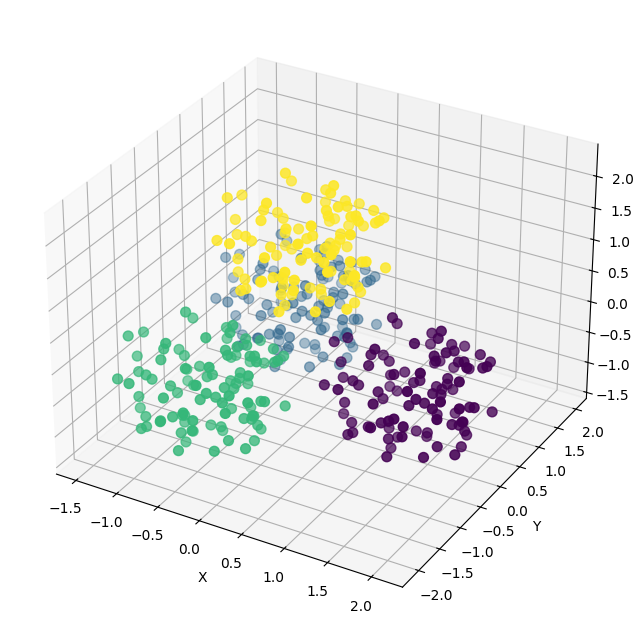

In [9]:
#visualizamos los datos en 3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tetra['X1'], tetra['X2'], tetra['X3'], c=labels['x'], cmap='viridis', s=50)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Realizamos los clusters

In [10]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering, AffinityPropagation, Birch, OPTICS, BisectingKMeans
from sklearn.mixture import GaussianMixture
n_clusters = np.unique(labels['x']).size
clustering_algorithms = {
    'KMeans': KMeans(n_clusters=n_clusters, random_state=42),
    'DBSCAN': DBSCAN(eps=0.7, min_samples=5),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=n_clusters),
    'MeanShift': MeanShift(),
    'SpectralClustering': SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors'),
    'AffinityPropagation': AffinityPropagation(),
    'Birch': Birch(n_clusters=n_clusters),
    'OPTICS': OPTICS(min_samples=5, cluster_method='xi', xi=0.05),
    'BisectingKMeans': BisectingKMeans(n_clusters=n_clusters, random_state=42),
    'GaussianMixture': GaussianMixture(n_components=n_clusters, random_state=42)
}
results = {}
for name, algorithm in clustering_algorithms.items():
    try:
        algorithm.fit(tetra)
        if hasattr(algorithm, 'labels_'):
            labels = algorithm.labels_
        elif hasattr(algorithm, 'predict'):
            labels = algorithm.predict(tetra)
        else:
            labels = algorithm.means_.argmax(axis=0)  # For GaussianMixture
        results[name] = labels
    except Exception as e:
        print(f"Error with {name}: {e}")

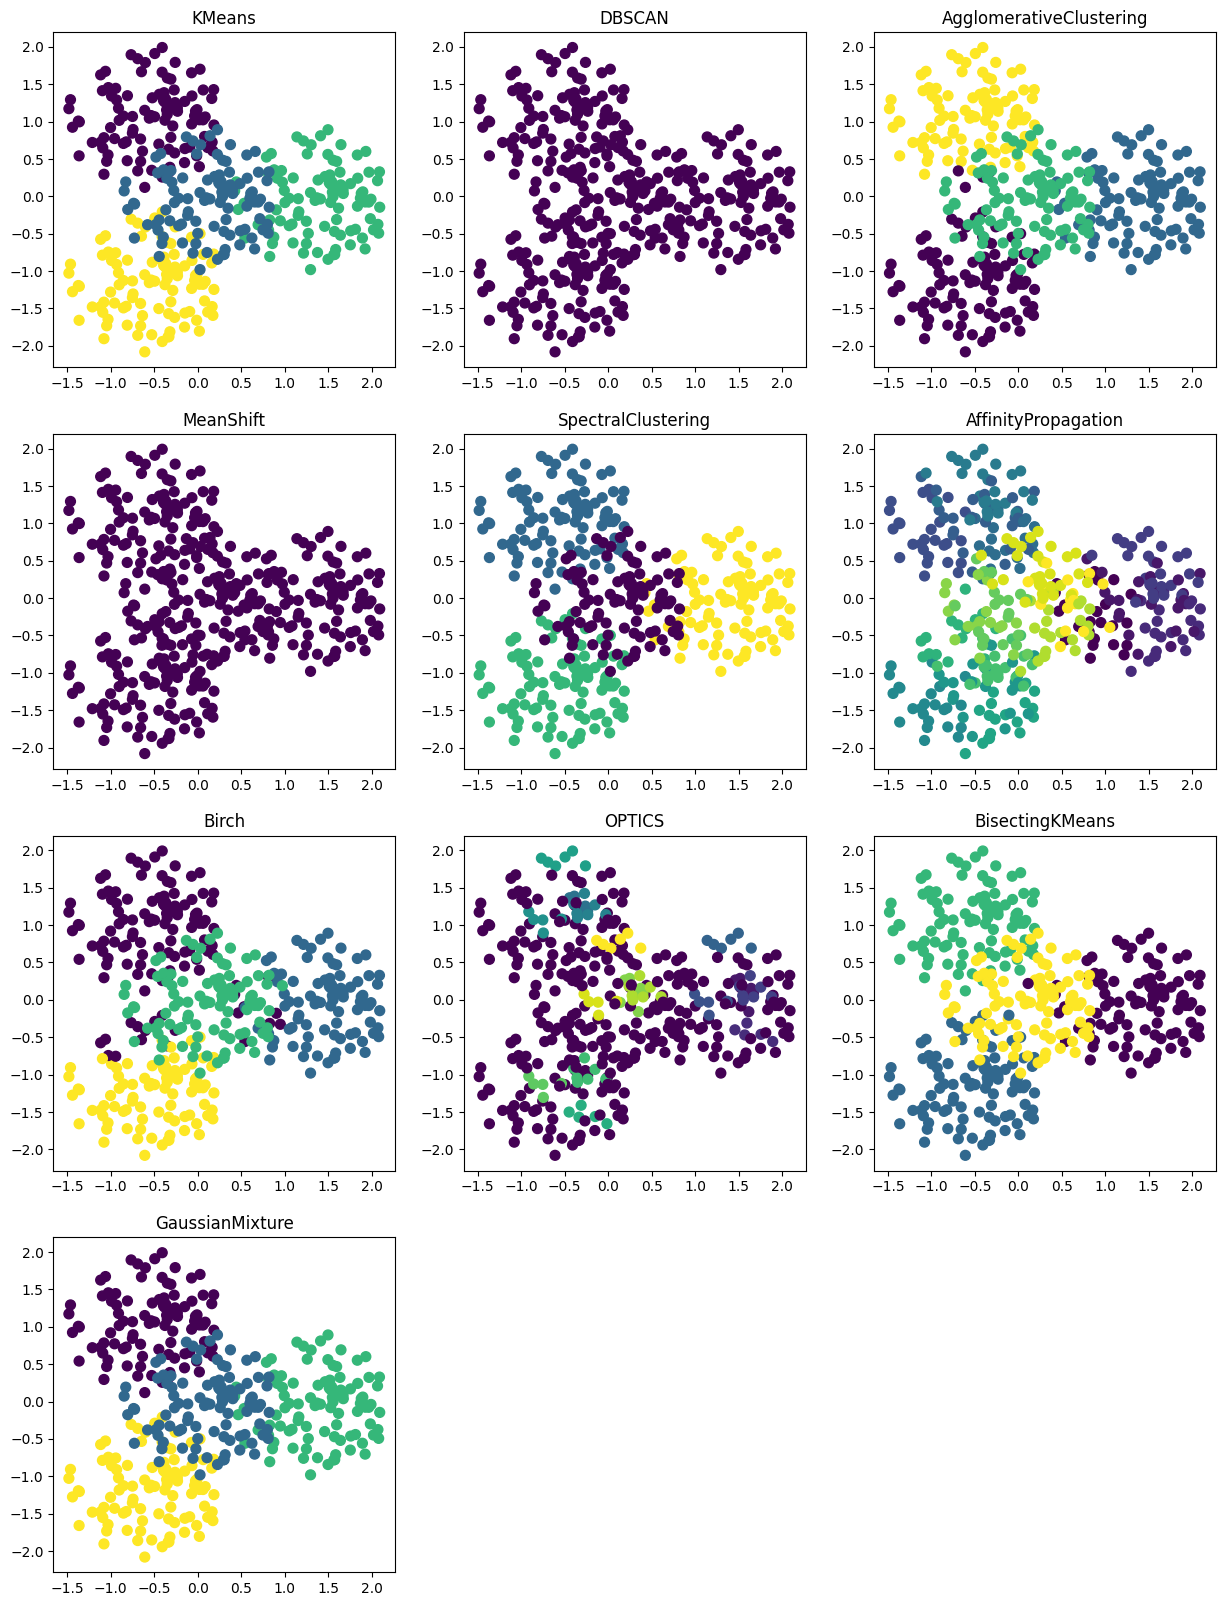

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 20))
for i, (name, labels) in enumerate(results.items(), 1):
    plt.subplot(4, 3, i)
    plt.scatter(tetra.iloc[:, 0], tetra.iloc[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(name)

In [12]:
#definimos dunn index
def dunn_index(data, labels):
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return 0.0

    inter_cluster_distances = []
    intra_cluster_distances = []

    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i = data[labels == unique_labels[i]]
            cluster_j = data[labels == unique_labels[j]]
            inter_distance = np.linalg.norm(cluster_i.mean(axis=0) - cluster_j.mean(axis=0))
            inter_cluster_distances.append(inter_distance)

        intra_distance = np.mean([np.linalg.norm(data[labels == unique_label] - data[labels == unique_label].mean(axis=0)) for unique_label in unique_labels])
        intra_cluster_distances.append(intra_distance)

    dunn_index_value = min(inter_cluster_distances) / max(intra_cluster_distances)
    return dunn_index_value

In [13]:
#podrias generar una metrica en que se calcule el valor maximo de distancia (entre las menores distancias de cada punto con otro dentro del mismo cluster) dividido por el valor minimo de distancia entre cualquier punto de un cluster con otro punto de otro cluster
import numpy as np
from sklearn.metrics import pairwise_distances

def custom_metric(X, labels):
    X = np.array(X)
    distances = pairwise_distances(X)
    n = len(X)
    
    # Numerador: máximo de las mínimas distancias dentro del mismo cluster
    max_min_intra = -np.inf
    for i in range(n):
        same_cluster = (labels == labels[i])
        same_cluster[i] = False  # Exclude itself
        if np.any(same_cluster):
            min_dist = np.min(distances[i][same_cluster])
            max_min_intra = max(max_min_intra, min_dist)
    
    # Denominador: mínima distancia entre puntos de distintos clusters
    min_inter = np.inf
    for i in range(n):
        other_cluster = (labels != labels[i])
        if np.any(other_cluster):
            min_dist = np.min(distances[i][other_cluster])
            min_inter = min(min_inter, min_dist)

    M = max_min_intra / min_inter if min_inter != 0 else np.inf
    return 1 /( 1 + M)


In [14]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from permetrics import ClusteringMetric
def evaluate_clustering(data, labels):
    if len(set(labels)) < 2:
        return {
            'Silhouette Score': None,
            'Calinski-Harabasz Score': None,
            'Davies-Bouldin Score': None,
            'Dunn Index': None,
            'custom_metric': None,
            'dbcv': None
        }
    
    silhouette = silhouette_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    dunn = dunn_index(data.values, labels)
    custom = custom_metric(data.values, labels)
    dbcv = ClusteringMetric(X=data.values, y_pred=labels).DBCVI()

    return {
        'Silhouette Score': silhouette,
        'Calinski-Harabasz Score': calinski_harabasz,
        'Davies-Bouldin Score': davies_bouldin,
        'Dunn Index': dunn,
        'custom_metric': custom,
        'dbcv': dbcv
    }
evaluation_results = {}
for name, labels in results.items():
    evaluation_results[name] = evaluate_clustering(tetra, labels)
evaluation_df = pd.DataFrame(evaluation_results).T
evaluation_df = evaluation_df.rename(columns={
    'Silhouette Score': 'Silhouette',
    'Calinski-Harabasz Score': 'Calinski-Harabasz',
    'Davies-Bouldin Score': 'Davies-Bouldin',
    'Dunn Index': 'Dunn',
    'custom_metric': 'Custom Metric'
})
evaluation_df

/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv
KMeans,0.505789,418.391209,0.662645,0.290729,0.476952,0.912157
DBSCAN,None,None,None,None,None,None
AgglomerativeClustering,0.495211,402.568867,0.687557,0.282185,0.421683,0.919217
MeanShift,None,None,None,None,None,None
SpectralClustering,0.505789,418.391209,0.662645,0.290729,0.476952,0.912157
AffinityPropagation,0.25035,202.728651,1.094664,0.33361,0.101385,0.991869
Birch,0.458901,344.605155,0.777212,0.255654,0.210882,0.932943
OPTICS,-0.36632,7.914871,1.23827,0.269208,0.199553,NaN
BisectingKMeans,0.502331,412.509853,0.671084,0.286864,0.22373,0.914388
GaussianMixture,0.505789,418.391209,0.662645,0.290729,0.476952,0.912157


In [15]:
#elige los mejores 3 resultados ponderando el orden de cada métrica
def weighted_score(row):
    weights = {
        'Silhouette': 0.2,
        'Calinski-Harabasz': -0.2,
        'Davies-Bouldin': 0.2,  # Negativo porque queremos minimizar
        'Dunn': 0.2,
        'Custom Metric': 0.5 # Puedes ajustar este peso según su importancia
    }
    score = (row['Silhouette'] * weights['Silhouette'] +
                1/(1+row['Calinski-Harabasz']) * weights['Calinski-Harabasz'] +
                1/(1+row['Davies-Bouldin']) * weights['Davies-Bouldin'] +
                row['Dunn'] * weights['Dunn'] +
                row['Custom Metric'] * weights['Custom Metric'])
    return score
# Replace None values with 0 for scoring
evaluation_df_filled = evaluation_df.fillna(0)
evaluation_df_filled['Weighted Score'] = evaluation_df_filled.apply(weighted_score, axis=1)
top_3_algorithms = evaluation_df_filled.nlargest(3, 'Weighted Score')
top_3_algorithms

/tmp/ipykernel_125832/2114172724.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  evaluation_df_filled = evaluation_df.fillna(0)


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv,Weighted Score
KMeans,0.505789,418.391209,0.662645,0.290729,0.476952,0.912157,0.517593
GaussianMixture,0.505789,418.391209,0.662645,0.290729,0.476952,0.912157,0.517593
SpectralClustering,0.505789,418.391209,0.662645,0.290729,0.476952,0.912157,0.517593


# Interpretar

In [16]:
import sys
sys.path.append('../../..')
from ripper import MultiClassRipperClassifier
from dsgd import DSClassifierMultiQ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree as sk_tree

In [17]:
# interpretamos solo los mejores 3 resultados y guardamos los modelos
saved_models = {}
top_3_labels = {name: results[name] for name in top_3_algorithms.index}
top_3_data = tetra.copy()
for name, labels in top_3_labels.items():
    n = len(np.unique(labels))
    X_train, X_test, y_train, y_test = train_test_split(top_3_data, labels, test_size=0.2, random_state=42)
    print(f'Processing {name} with {n} clusters')
    
    # Ripper
    ripper = MultiClassRipperClassifier(random_state=43)
    ripper.fit(X_train, y_train)
    y_pred_ripper = ripper.predict(X_test)
    print(f'Ripper Accuracy for {name}: {accuracy_score(y_test, y_pred_ripper):.2f}')
    saved_models.setdefault(name, {})['ripper'] = ripper
    
    # Decision Tree
    dtree = DecisionTreeClassifier(random_state=42, max_depth=5)
    dtree.fit(X_train, y_train)
    dtree_pred = dtree.predict(X_test)
    print(f'Decision Tree Accuracy for {name}: {accuracy_score(y_test, dtree_pred):.2f}')
    saved_models[name]['dtree'] = dtree
    
    # DSGD
    ds = DSClassifierMultiQ(n, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
    X = X_train.to_numpy()
    losses, epoch, dt = ds.fit(X, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=X_train.columns)
    x_test = X_test.to_numpy()
    y_pred_ds = ds.predict(x_test)
    print(f'DSGD Accuracy for {name}: {accuracy_score(y_test, y_pred_ds):.2f}')
    saved_models[name]['ds'] = ds
    
    print('--' * 40)


Processing KMeans with 4 clusters
Ripper Accuracy for KMeans: 0.90
Decision Tree Accuracy for KMeans: 1.00
Optimization started

Training time: 8.65s, epochs: 147

Least training loss reached: 0.012
DSGD Accuracy for KMeans: 0.99
--------------------------------------------------------------------------------
Processing GaussianMixture with 4 clusters
Ripper Accuracy for GaussianMixture: 0.90
Decision Tree Accuracy for GaussianMixture: 1.00
Optimization started

Training time: 9.99s, epochs: 171

Least training loss reached: 0.008
DSGD Accuracy for GaussianMixture: 0.99
--------------------------------------------------------------------------------
Processing SpectralClustering with 4 clusters
Ripper Accuracy for SpectralClustering: 0.90
Decision Tree Accuracy for SpectralClustering: 1.00
Optimization started

Training time: 9.06s, epochs: 156

Least training loss reached: 0.011
DSGD Accuracy for SpectralClustering: 0.99
----------------------------------------------------------------

# Primer algoritmo

In [18]:
#interpretamos primer algoritmo
models = saved_models[top_3_algorithms.index[0]]
print('Ripper Rules:')
models['ripper'].print_rules()

Ripper Rules:

Reglas para clase: 0
[[X2=>1.17] V [X2=0.73-1.17^X1=-0.055-0.12] V [X2=0.73-1.17^X1=<-0.9] V [X2=0.73-1.17^X3=<-0.96] V [X2=0.39-0.73^X1=-0.27--0.055] V [X2=0.39-0.73^X1=-0.9--0.61] V [X2=0.73-1.17^X1=-0.39--0.27] V [X2=0.39-0.73^X1=<-0.9]]

Reglas para clase: 1
[[X3=>1.5] V [X3=0.97-1.5] V [X3=0.25-0.97^X1=0.12-0.38] V [X3=0.25-0.97^X1=0.38-0.83] V [X3=0.25-0.97^X1=-0.27--0.055^X2=-0.033-0.2] V [X3=0.25-0.97^X2=-0.32--0.033] V [X3=0.25-0.97^X2=0.2-0.39] V [X2=-0.033-0.2^X1=-0.39--0.27]]

Reglas para clase: 2
[[X1=>1.51] V [X1=0.83-1.51] V [X1=0.38-0.83^X3=-0.37--0.25] V [X1=0.38-0.83^X3=-0.51--0.37] V [X1=0.38-0.83^X3=-0.96--0.71] V [X1=0.38-0.83^X3=-0.71--0.51] V [X2=-0.32--0.033^X3=<-0.96]]

Reglas para clase: 3
[[X2=<-1.26] V [X2=-1.26--0.84] V [X2=-0.84--0.53^X1=-0.39--0.27] V [X2=-0.84--0.53^X3=-0.71--0.51] V [X3=-0.25-0.045^X2=-0.32--0.033] V [X1=<-0.9^X2=-0.53--0.32]]


Decision Tree:


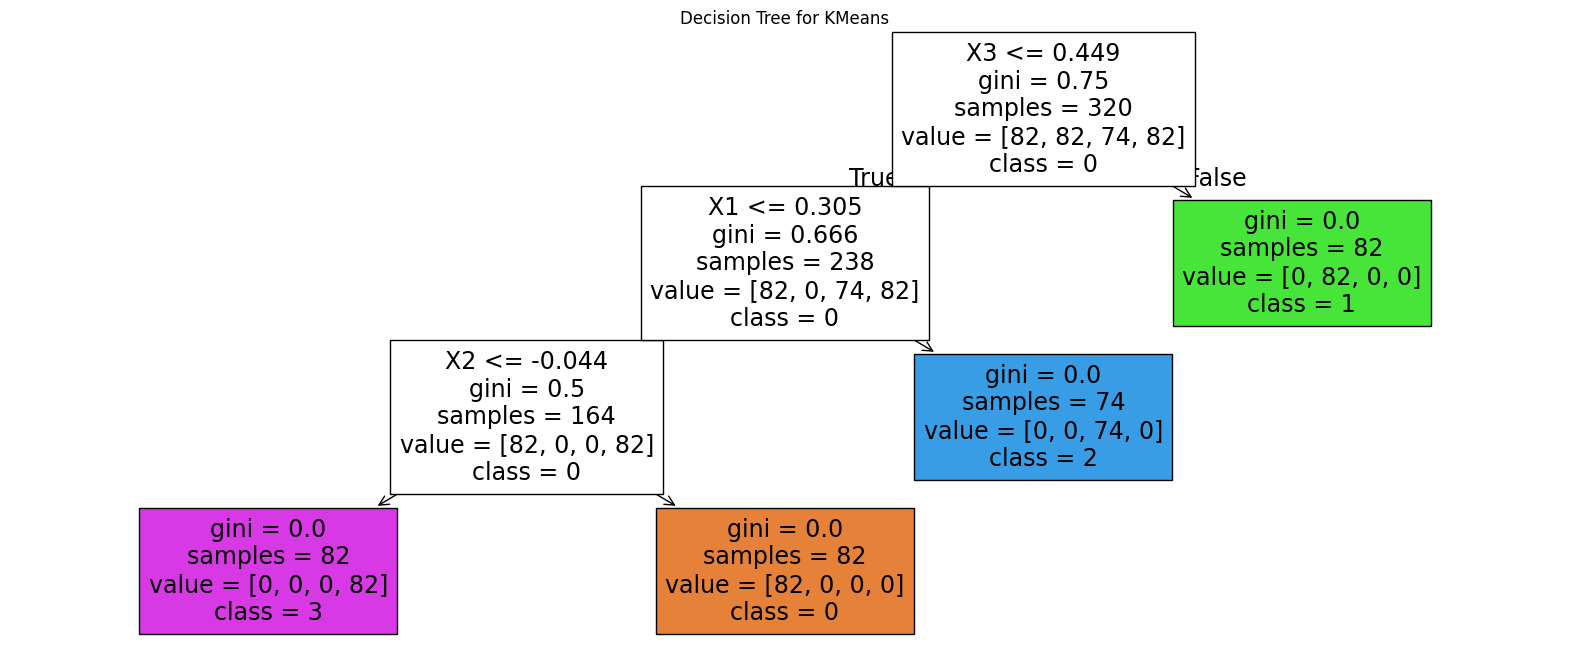

In [19]:
print('Decision Tree:')
plt.figure(figsize=(20, 8))
sk_tree.plot_tree(models['dtree'], filled=True, feature_names=tetra.columns, class_names=np.unique(top_3_labels[top_3_algorithms.index[0]]).astype(str))
plt.title(f'Decision Tree for {top_3_algorithms.index[0]}')
plt.show()

In [20]:
print('DSGD Rules:')
models['ds'].print_most_important_rules(threshold=0.32)
print('--' * 40)

DSGD Rules:


Most important rules for class 0

	[0.779] R7: X2 > 0.561
			0: 0.607	1: 0.292	2: 0.101	3: 0.000	Unc: 0.000

	[0.571] R0: X1 < -0.478
			0: 0.326	1: 0.229	2: 0.000	3: 0.443	Unc: 0.002

	[0.412] R1: -0.478 < X1 < 0.100
			0: 0.170	1: 0.557	2: 0.000	3: 0.270	Unc: 0.003

	[0.386] R8: X3 < -0.576
			0: 0.149	1: 0.000	2: 0.527	3: 0.324	Unc: 0.001

	[0.364] R6: -0.050 < X2 < 0.561
			0: 0.133	1: 0.609	2: 0.256	3: 0.000	Unc: 0.001

Most important rules for class 1

	[0.780] R6: -0.050 < X2 < 0.561
			0: 0.133	1: 0.609	2: 0.256	3: 0.000	Unc: 0.001

	[0.778] R5: -0.660 < X2 < -0.050
			0: 0.000	1: 0.637	2: 0.240	3: 0.074	Unc: 0.049

	[0.745] R1: -0.478 < X1 < 0.100
			0: 0.170	1: 0.557	2: 0.000	3: 0.270	Unc: 0.003

	[0.656] R2: 0.100 < X1 < 0.678
			0: 0.019	1: 0.622	2: 0.000	3: 0.051	Unc: 0.307

	[0.556] R11: X3 > 0.644
			0: 0.000	1: 0.556	2: 0.000	3: 0.000	Unc: 0.444

	[0.540] R7: X2 > 0.561
			0: 0.607	1: 0.292	2: 0.101	3: 0.000	Unc: 0.000

	[0.478] R0: X1 < -0.478
			0: 0.326

# Segundo algoritmo

In [21]:
#interpretamos primer algoritmo
models = saved_models[top_3_algorithms.index[1]]
print('Ripper Rules:')
models['ripper'].print_rules()

Ripper Rules:

Reglas para clase: 0
[[X2=>1.17] V [X2=0.73-1.17^X1=-0.055-0.12] V [X2=0.73-1.17^X1=<-0.9] V [X2=0.73-1.17^X3=<-0.96] V [X2=0.39-0.73^X1=-0.27--0.055] V [X2=0.39-0.73^X1=-0.9--0.61] V [X2=0.73-1.17^X1=-0.39--0.27] V [X2=0.39-0.73^X1=<-0.9]]

Reglas para clase: 1
[[X3=>1.5] V [X3=0.97-1.5] V [X3=0.25-0.97^X1=0.12-0.38] V [X3=0.25-0.97^X1=0.38-0.83] V [X3=0.25-0.97^X1=-0.27--0.055^X2=-0.033-0.2] V [X3=0.25-0.97^X2=-0.32--0.033] V [X3=0.25-0.97^X2=0.2-0.39] V [X2=-0.033-0.2^X1=-0.39--0.27]]

Reglas para clase: 2
[[X1=>1.51] V [X1=0.83-1.51] V [X1=0.38-0.83^X3=-0.37--0.25] V [X1=0.38-0.83^X3=-0.51--0.37] V [X1=0.38-0.83^X3=-0.96--0.71] V [X1=0.38-0.83^X3=-0.71--0.51] V [X2=-0.32--0.033^X3=<-0.96]]

Reglas para clase: 3
[[X2=<-1.26] V [X2=-1.26--0.84] V [X2=-0.84--0.53^X1=-0.39--0.27] V [X2=-0.84--0.53^X3=-0.71--0.51] V [X3=-0.25-0.045^X2=-0.32--0.033] V [X1=<-0.9^X2=-0.53--0.32]]


Decision Tree:


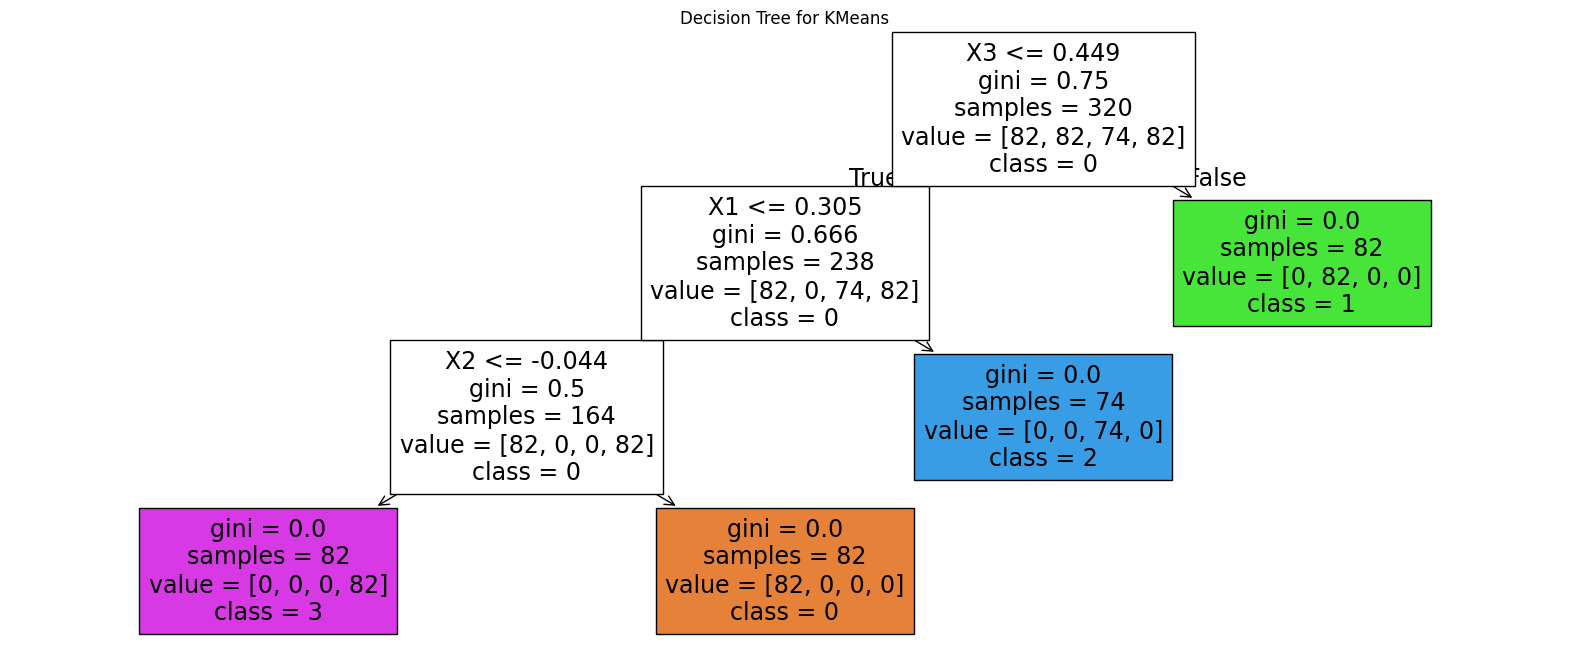

In [22]:
print('Decision Tree:')
plt.figure(figsize=(20, 8))
sk_tree.plot_tree(models['dtree'], filled=True, feature_names=tetra.columns, class_names=np.unique(top_3_labels[top_3_algorithms.index[1]]).astype(str))
plt.title(f'Decision Tree for {top_3_algorithms.index[0]}')
plt.show()

In [23]:
print('DSGD Rules:')
models['ds'].print_most_important_rules(threshold=0.32)
print('--' * 40)

DSGD Rules:


Most important rules for class 0

	[0.772] R7: X2 > 0.561
			0: 0.596	1: 0.292	2: 0.112	3: 0.000	Unc: 0.000

	[0.624] R0: X1 < -0.478
			0: 0.390	1: 0.223	2: 0.000	3: 0.386	Unc: 0.001

	[0.552] R8: X3 < -0.576
			0: 0.305	1: 0.000	2: 0.542	3: 0.153	Unc: 0.000

	[0.455] R1: -0.478 < X1 < 0.100
			0: 0.208	1: 0.611	2: 0.000	3: 0.179	Unc: 0.002

	[0.446] R9: -0.576 < X3 < 0.034
			0: 0.199	1: 0.000	2: 0.660	3: 0.141	Unc: 0.000

	[0.408] R10: 0.034 < X3 < 0.644
			0: 0.170	1: 0.000	2: 0.600	3: 0.212	Unc: 0.018

Most important rules for class 1

	[0.801] R5: -0.660 < X2 < -0.050
			0: 0.000	1: 0.649	2: 0.203	3: 0.138	Unc: 0.011

	[0.786] R6: -0.050 < X2 < 0.561
			0: 0.088	1: 0.633	2: 0.256	3: 0.000	Unc: 0.024

	[0.781] R1: -0.478 < X1 < 0.100
			0: 0.208	1: 0.611	2: 0.000	3: 0.179	Unc: 0.002

	[0.704] R2: 0.100 < X1 < 0.678
			0: 0.085	1: 0.639	2: 0.000	3: 0.052	Unc: 0.225

	[0.648] R11: X3 > 0.644
			0: 0.000	1: 0.648	2: 0.000	3: 0.000	Unc: 0.352

	[0.540] R7: X2 > 0.561
			

# Tercer algoritmo

In [24]:
#interpretamos primer algoritmo
models = saved_models[top_3_algorithms.index[2]]
print('Ripper Rules:')
models['ripper'].print_rules()

Ripper Rules:

Reglas para clase: 0
[[X3=>1.5] V [X3=0.97-1.5] V [X3=0.25-0.97^X1=0.12-0.38] V [X3=0.25-0.97^X1=0.38-0.83] V [X3=0.25-0.97^X1=-0.27--0.055^X2=-0.033-0.2] V [X3=0.25-0.97^X2=-0.32--0.033] V [X3=0.25-0.97^X2=0.2-0.39] V [X2=-0.033-0.2^X1=-0.39--0.27]]

Reglas para clase: 1
[[X2=>1.17] V [X2=0.73-1.17^X1=-0.055-0.12] V [X2=0.73-1.17^X1=<-0.9] V [X2=0.73-1.17^X3=<-0.96] V [X2=0.39-0.73^X1=-0.27--0.055] V [X2=0.39-0.73^X1=-0.9--0.61] V [X2=0.73-1.17^X1=-0.39--0.27] V [X2=0.39-0.73^X1=<-0.9]]

Reglas para clase: 2
[[X2=<-1.26] V [X2=-1.26--0.84] V [X2=-0.84--0.53^X1=-0.39--0.27] V [X2=-0.84--0.53^X3=-0.71--0.51] V [X3=-0.25-0.045^X2=-0.32--0.033] V [X1=<-0.9^X2=-0.53--0.32]]

Reglas para clase: 3
[[X1=>1.51] V [X1=0.83-1.51] V [X1=0.38-0.83^X3=-0.37--0.25] V [X1=0.38-0.83^X3=-0.51--0.37] V [X1=0.38-0.83^X3=-0.96--0.71] V [X1=0.38-0.83^X3=-0.71--0.51] V [X2=-0.32--0.033^X3=<-0.96]]


Decision Tree:


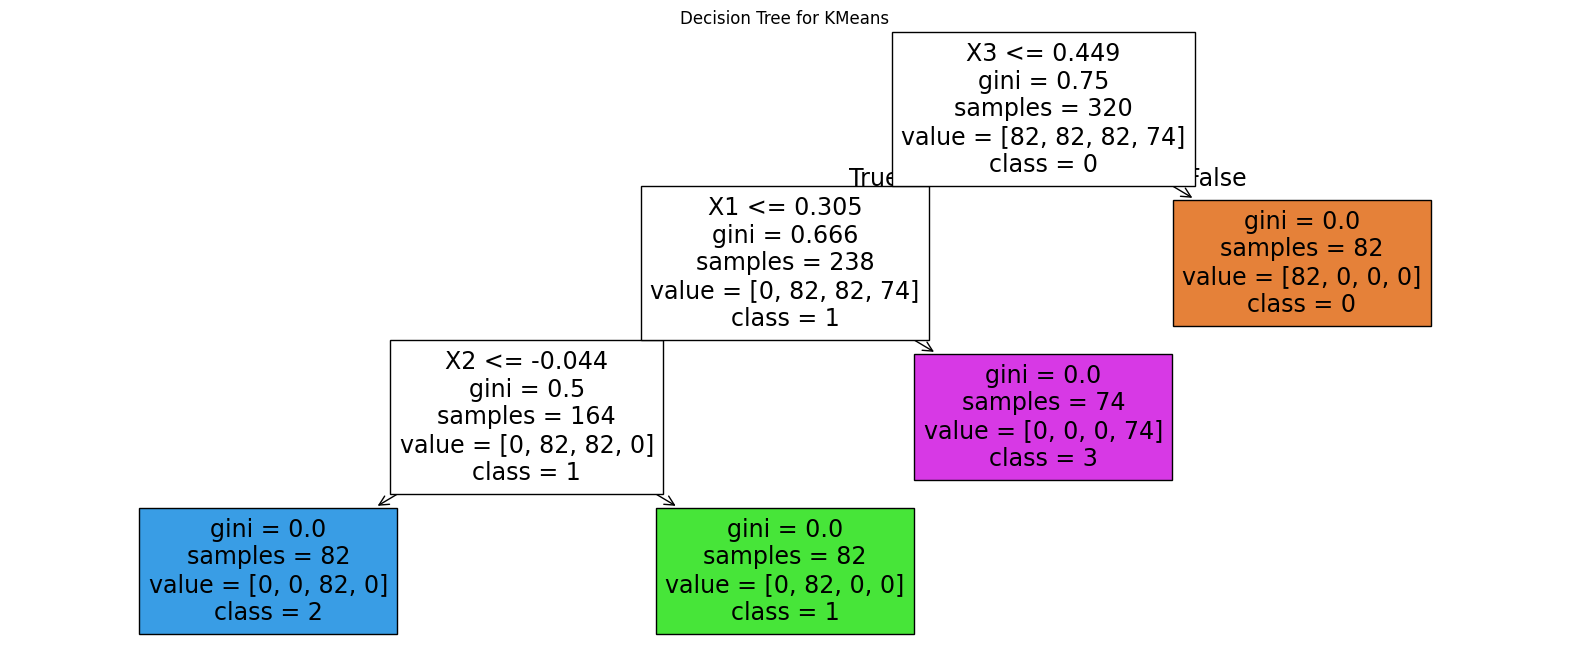

In [25]:
print('Decision Tree:')
plt.figure(figsize=(20, 8))
sk_tree.plot_tree(models['dtree'], filled=True, feature_names=tetra.columns, class_names=np.unique(top_3_labels[top_3_algorithms.index[2]]).astype(str))
plt.title(f'Decision Tree for {top_3_algorithms.index[0]}')
plt.show()

In [26]:
print('DSGD Rules:')
models['ds'].print_most_important_rules(threshold=0.32)
print('--' * 40)

DSGD Rules:


Most important rules for class 0

	[0.779] R5: -0.660 < X2 < -0.050
			0: 0.629	1: 0.000	2: 0.105	3: 0.233	Unc: 0.034

	[0.775] R6: -0.050 < X2 < 0.561
			0: 0.604	1: 0.132	2: 0.000	3: 0.258	Unc: 0.006

	[0.757] R1: -0.478 < X1 < 0.100
			0: 0.576	1: 0.184	2: 0.237	3: 0.000	Unc: 0.003

	[0.675] R2: 0.100 < X1 < 0.678
			0: 0.615	1: 0.063	2: 0.063	3: 0.000	Unc: 0.259

	[0.594] R11: X3 > 0.644
			0: 0.594	1: 0.000	2: 0.000	3: 0.000	Unc: 0.406

	[0.551] R7: X2 > 0.561
			0: 0.303	1: 0.594	2: 0.000	3: 0.102	Unc: 0.000

	[0.490] R0: X1 < -0.478
			0: 0.240	1: 0.345	2: 0.415	3: 0.000	Unc: 0.000

	[0.427] R4: X2 < -0.660
			0: 0.197	1: 0.000	2: 0.652	3: 0.078	Unc: 0.073

	[0.405] R3: X1 > 0.678
			0: 0.221	1: 0.000	2: 0.000	3: 0.523	Unc: 0.256

Most important rules for class 1

	[0.771] R7: X2 > 0.561
			0: 0.303	1: 0.594	2: 0.000	3: 0.102	Unc: 0.000

	[0.587] R0: X1 < -0.478
			0: 0.240	1: 0.345	2: 0.415	3: 0.000	Unc: 0.000

	[0.428] R1: -0.478 < X1 < 0.100
			0: 0.576	1: 0.184